In [1]:
# Ultralytics YOLOv5 🚀, AGPL-3.0 license
"""
Train a YOLOv5 model on a custom dataset. Models and datasets download automatically from the latest YOLOv5 release.

Usage - Single-GPU training:
    $ python train.py --data coco128.yaml --weights yolov5s.pt --img 640  # from pretrained (recommended)
    $ python train.py --data coco128.yaml --weights '' --cfg yolov5s.yaml --img 640  # from scratch

Usage - Multi-GPU DDP training:
    $ python -m torch.distributed.run --nproc_per_node 4 --master_port 1 train.py --data coco128.yaml --weights yolov5s.pt --img 640 --device 0,1,2,3

Models:     https://github.com/ultralytics/yolov5/tree/master/models
Datasets:   https://github.com/ultralytics/yolov5/tree/master/data
Tutorial:   https://docs.ultralytics.com/yolov5/tutorials/train_custom_data
"""

import argparse
import math
import os
import random
import subprocess
import sys
import time
from copy import deepcopy
from datetime import datetime, timedelta
from pathlib import Path

try:
    import comet_ml  # must be imported before torch (if installed)
except ImportError:
    comet_ml = None

import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import yaml
from torch.optim import lr_scheduler
from tqdm import tqdm

# FILE = Path(__file__).resolve()
# ROOT = FILE.parents[0]  # YOLOv5 root directory
# if str(ROOT) not in sys.path:
#     sys.path.append(str(ROOT))  # add ROOT to PATH
# ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

import val as validate  # for end-of-epoch mAP
from models.experimental import attempt_load
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.autobatch import check_train_batch_size
from utils.callbacks import Callbacks
from utils.dataloaders import create_dataloader
from utils.downloads import attempt_download, is_url
from utils.general import (
    LOGGER,
    TQDM_BAR_FORMAT,
    check_amp,
    check_dataset,
    check_file,
    check_git_info,
    check_git_status,
    check_img_size,
    check_requirements,
    check_suffix,
    check_yaml,
    colorstr,
    get_latest_run,
    increment_path,
    init_seeds,
    intersect_dicts,
    labels_to_class_weights,
    labels_to_image_weights,
    methods,
    one_cycle,
    print_args,
    print_mutation,
    strip_optimizer,
    yaml_save,
)
from utils.loggers import LOGGERS, Loggers
from utils.loggers.comet.comet_utils import check_comet_resume
from utils.loss import ComputeLoss
from utils.metrics import fitness
from utils.plots import plot_evolve
from utils.torch_utils import (
    EarlyStopping,
    ModelEMA,
    de_parallel,
    select_device,
    smart_DDP,
    smart_optimizer,
    smart_resume,
    torch_distributed_zero_first,
)

LOCAL_RANK = int(os.getenv("LOCAL_RANK", -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv("RANK", -1))
WORLD_SIZE = int(os.getenv("WORLD_SIZE", 1))
GIT_INFO = check_git_info()

In [30]:
train_path = 'D:\\disk B\\Academics\\Semester 8\\Model_17_12_24_v1\\YoloModel\\yolov5\\data1\\train\\images'
imgsz = 1280
batch_size=4
gs = 32
single_cls = False
hyp = {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
rect = False
workers = 8
image_weights = False
quad = False
seed = 42


In [31]:
import matplotlib.pyplot as plt
import torchvision
coco_idx_to_label= ["armchair","bed","door1","door2","sink1","sink2","sink3","sink4","sofa1"
        ,"sofa2"
        ,"table1"
        ,"table2"
        ,"table3"
        ,"tub"
        ,"window1"
        ,"window2"]
count = 200
def show_image(image, label=None):
    if label != None:
        boxes = torchvision.ops.box_convert(boxes=label[:,2:6] * 1280, in_fmt="cxcywh", out_fmt="xyxy")
        classes = []
        for obj in label:
            class_idx = int(obj[1].item())
            classes.append(str(obj[6].item()*360))
            # print()
            # classes.append(coco_idx_to_label[class_idx])
        image = torchvision.utils.draw_bounding_boxes(image, boxes, labels=classes, colors="red", width=2, font_size=400)
    image = image.permute(1, 2, 0)
    plt.imshow(image.squeeze())
    #plt.title(f'Label: {label}')
    global count
    count += 1
    plt.savefig(f'./data/images/img{count}.jpg',dpi=1000)
    plt.show()

In [32]:

train_loader, dataset = create_dataloader(
        train_path,
        imgsz,
        batch_size // WORLD_SIZE,
        gs,
        single_cls,
        hyp=hyp,
        augment=True,
        cache=None,
        rect=rect,
        rank=LOCAL_RANK,
        workers=workers,
        image_weights=image_weights,
        quad=quad,
        prefix=colorstr("train: "),
        shuffle=True,
        seed=seed,
    )

train: Scanning D:\disk B\Academics\Semester 8\Model_17_12_24_v1\YoloModel\yolov5\data1\train\labels.cache... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<?, ?it/s]


dict_values([[array([[          2,     0.12355,     0.62757,    0.064615,     0.12694,           0],
       [          2,     0.41008,     0.67442,    0.064615,     0.12694,         0.5],
       [          2,     0.70464,     0.64374,    0.072772,     0.10635,           0],
       [          2,     0.92863,     0.14965,    0.064615,     0.12694,         0.5],
       [          2,     0.92859,     0.75991,    0.064615,     0.12694,         0.5],
       [         14,     0.43518,     0.06333,    0.048039,    0.026019,        0.75],
       [         14,     0.57114,    0.063601,    0.048039,    0.026019,        0.75],
       [         14,     0.66519,    0.063382,    0.047477,    0.025755,        0.75],
       [         14,     0.76153,    0.063264,    0.047477,    0.025755,        0.75],
       [         14,     0.95441,     0.59342,    0.013323,    0.093812,         0.5],
       [         14,     0.40052,     0.84641,    0.048039,    0.026019,        0.25],
       [         14,     0.54

In [7]:
y1.shape
print(y1[0])

tensor([0.00000, 2.00000, 0.13070, 0.42032, 0.06774, 0.06810, 0.50000])


torch.Size([3, 1280, 1280])
torch.Size([62, 7])
D:\disk B\Academics\Semester 8\Model_17_12_24_v1\YoloModel\yolov5\data1\train\images\floor_image_701.jpg


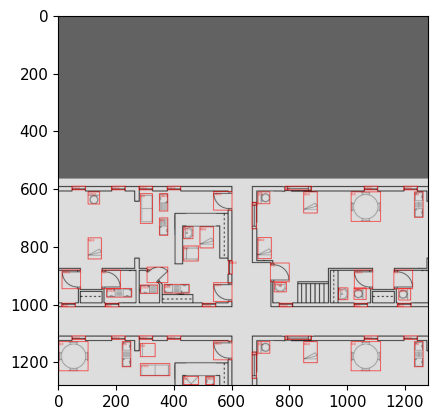

In [33]:
%matplotlib inline
x1, y1, path, _ = dataset[0]
print(x1.shape) # 3x640x640
print(y1.shape) # n_obj*6: 
print(path)
show_image(x1, y1)
# show_image(x1.view(3,1280,1280), y1)

torch.Size([4, 3, 1280, 1280])
torch.Size([225, 7])
D:\disk B\Academics\Semester 8\Model_17_12_24_v1\YoloModel\yolov5\data1\train\images\floor_image_706.jpg


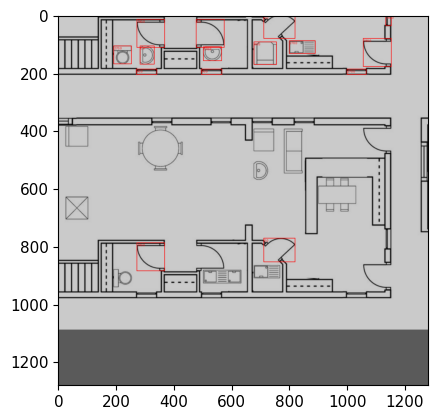

In [34]:
for X, y, paths, _ in train_loader:
    break
# y is of shape number_objs*6
# 6: image_index, class_index, x, y, w, h
print(X.shape)
print(y.shape)
print(paths[0])
show_image(X[0], y[:15])
# eop

In [35]:
cfg = './models/yolov5s.yaml'
device = 'cpu'
model = Model(cfg, ch=3, nc=16, anchors=hyp.get('anchors')).to(device)

Overriding model.yaml nc=80 with nc=16

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]            

In [36]:
len(model.model), model.model

(25,
 Sequential(
   (0): Conv(
     (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
     (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
     (act): SiLU(inplace=True)
   )
   (1): Conv(
     (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
     (act): SiLU(inplace=True)
   )
   (2): C3(
     (cv1): Conv(
       (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (cv2): Conv(
       (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (cv3): Conv(
       (conv): Conv2d(64, 64,

In [37]:
X = X.to(device).float() / 255
print(X.shape)
# preds = model(X)
# len(preds)
# print(preds[0].shape)
# print(preds[1].shape)
# print(preds[2].shape)

torch.Size([4, 3, 1280, 1280])


In [15]:
pred = model.model[0](X)
print(pred.shape)

torch.Size([4, 32, 640, 640])


In [16]:
pred = model.model[1](pred)
print(pred.shape)

torch.Size([4, 64, 320, 320])


In [17]:
pred = model.model[2](pred)
print(pred.shape)

torch.Size([4, 64, 320, 320])


In [38]:
pred = model.model[0](X)
print(0,pred.shape)
for i in range(1,25):
    pred = model.model[i](pred)
    print(i,pred.shape)

0 torch.Size([4, 32, 640, 640])
1 torch.Size([4, 64, 320, 320])
2 torch.Size([4, 64, 320, 320])
3 torch.Size([4, 128, 160, 160])
4 torch.Size([4, 128, 160, 160])
5 torch.Size([4, 256, 80, 80])
6 torch.Size([4, 256, 80, 80])
7 torch.Size([4, 512, 40, 40])
8 torch.Size([4, 512, 40, 40])
9 torch.Size([4, 512, 40, 40])
10 torch.Size([4, 256, 40, 40])
11 torch.Size([4, 256, 80, 80])


TypeError: cat() received an invalid combination of arguments - got (Tensor, int), but expected one of:
 * (tuple of Tensors tensors, int dim = 0, *, Tensor out = None)
 * (tuple of Tensors tensors, name dim, *, Tensor out = None)
